# Libraries and Data

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

In [27]:
train = pd.read_csv("../data/advanced_train.csv", low_memory = False)
test = pd.read_csv("../data/advanced_test.csv", low_memory = False)
sample = pd.read_csv("../data/sample_submission.csv", low_memory = False)

In [28]:
train.shape, test.shape

((37439, 40), (10000, 39))

In [29]:
train.columns, test.columns, train.dtypes

(Index(['Id', 'Sold Price', 'Summary', 'Type', 'Year built', 'Heating',
        'Cooling', 'Parking', 'Lot', 'Bedrooms', 'Bathrooms', 'Full bathrooms',
        'Total interior livable area', 'Total spaces', 'Garage spaces',
        'Region', 'Elementary School', 'Elementary School Score',
        'Elementary School Distance', 'Middle School', 'Middle School Score',
        'Middle School Distance', 'High School', 'High School Score',
        'High School Distance', 'Flooring', 'Heating features',
        'Cooling features', 'Appliances included', 'Laundry features',
        'Parking features', 'Tax assessed value', 'Annual tax amount',
        'Listed On', 'Listed Price', 'Last Sold On', 'Last Sold Price', 'City',
        'Zip', 'State'],
       dtype='object'),
 Index(['Id', 'Summary', 'Type', 'Year built', 'Heating', 'Cooling', 'Parking',
        'Lot', 'Bedrooms', 'Bathrooms', 'Full bathrooms',
        'Total interior livable area', 'Total spaces', 'Garage spaces',
        'Region',

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37439 entries, 0 to 37438
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Id                           37439 non-null  int64  
 1   Sold Price                   37439 non-null  int64  
 2   Summary                      37176 non-null  object 
 3   Type                         37439 non-null  object 
 4   Year built                   36686 non-null  float64
 5   Heating                      32481 non-null  object 
 6   Cooling                      29109 non-null  object 
 7   Parking                      36720 non-null  object 
 8   Lot                          26041 non-null  float64
 9   Bedrooms                     35235 non-null  object 
 10  Bathrooms                    34786 non-null  float64
 11  Full bathrooms               31696 non-null  float64
 12  Total interior livable area  35443 non-null  float64
 13  Total spaces    

# Data Pre-Processing

<AxesSubplot:xlabel='State', ylabel='Count'>

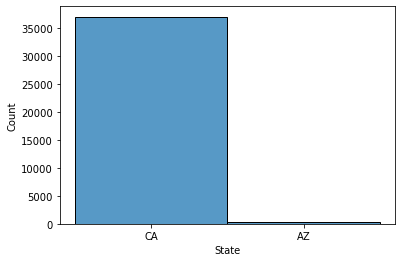

In [31]:
#sns.histplot(np.log(train["Sold Price"]))
sns.histplot(train["State"])
#train["Year built"].unique()


In [32]:
train["State"].isna().any()

False

In [33]:
np.min(train["Year built"])

0.0

Impute missing values for certain numeric variables

In [34]:
def preprocess_data(df):
    df["Total interior livable area"] = df["Total interior livable area"].fillna(df["Total interior livable area"].median())
    df["Bathrooms"] = df["Bathrooms"].fillna(df["Bathrooms"].median())
    df["Year built"] = df["Year built"].fillna(df["Year built"].median())
    df["Year built"] = np.maximum(df["Year built"], 1870)
    df["Year built"] = np.minimum(df["Year built"], 2022)
    df["state_ind"] = df["State"] == "CA"
    
    return df


In [35]:
train = preprocess_data(train)

Transform the target by logging it since it's got a long right tail

In [36]:
y = np.log(train["Sold Price"])

In [37]:
pred_vars = ["Listed Price", "Total interior livable area", "Bathrooms", "Year built", "state_ind"]

X = train[pred_vars]

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=56)

# Models

In [39]:
model = GradientBoostingRegressor(n_estimators=200, 
                                  learning_rate=0.1,
                                  max_depth=3, 
                                  random_state=56,
                                  loss='squared_error')

In [40]:
model.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=200, random_state=56)

In [41]:
model.score(X_test, y_test)

0.9278767040935049

Train final model with all the data

In [42]:
model = GradientBoostingRegressor(n_estimators=200, 
                                  learning_rate=0.1,
                                  max_depth=3, 
                                  random_state=56,
                                  loss='squared_error').fit(X, y)

# Make Predictions

Do the same pre-processing on the test data that we do on the train data

In [43]:
test = preprocess_data(test)


In [44]:
test["Sold Price"] = np.exp(model.predict(test[pred_vars]))

In [45]:
test[["Id", "Sold Price"]].to_csv("../submission.csv", index = False)